## Assignment - 2: MLP - IRIS Data Classification 
### ID: eo9232
### Name: Md Reza
### IE7860 - Winter 2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')
iris = load_iris()

## Data Exploration 

In [2]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert to float
iris_df = iris_df.astype(float)
# Append "target"
iris_df['label'] = iris.target
# Use string label
iris_df['label'] = iris_df.label.replace(dict(enumerate(iris.target_names)))

In [3]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## **Data Preprocessing**

## **Handling Missing Values** ##

In [4]:
iris_df.isnull().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
label                False
dtype: bool

In [5]:
print("Number of rows with 0 values for each variable")
for col in iris_df.columns:
    missing_rows = iris_df.loc[iris_df[col]==0].shape[0]
    print(col + ": " + str(missing_rows))

Number of rows with 0 values for each variable
sepal length (cm): 0
sepal width (cm): 0
petal length (cm): 0
petal width (cm): 0
label: 0


## Data Preperation

In [6]:
# One-hot encodind - Categorical data
label = pd.get_dummies(iris_df['label'])
label.columns = ['label_' + str(x) for x in label.columns]
iris_df = pd.concat([iris_df, label], axis=1)
iris_df.drop(['label'], axis=1, inplace=True)

In [7]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_setosa,label_versicolor,label_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [8]:
# Create the input and target
X = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = iris_df[['label_setosa', 'label_versicolor', 'label_virginica']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert DataFrame into np array
X_scaled = np.asarray(X)
y = np.asarray(y)

#### Split the data set in a training set and a test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

## Hyper-parameters tune with GridSearchCV to Find the Best Activation Function & Optimizer

In [10]:
grid = {'solver': ['adam','sgd', 'adamx'], 'activation': ['softmax', 'sigmoid', 'relu']}
clf_cv = GridSearchCV(MLPClassifier(random_state=1, max_iter=5000, hidden_layer_sizes=(3,3), alpha=1e-5), grid, n_jobs=-1, cv=10)
clf_cv.fit(X_train, y_train)

print('\x1b[1;03;30;46m'+'GridSearch():\x1b[0m\n')
combination = 1
for x in grid.values():
    combination *= len(x)
print('This GridSearch has {} combinations.'.format(combination))
print("Best Configuration: ",clf_cv.best_params_)
print("Accuracy CV:",clf_cv.best_score_)
ppn_cv = clf_cv.best_estimator_
print('Test accuracy: %.3f' % clf_cv.score(X_test, y_test))

GridSearch():

This GridSearch has 9 combinations.
Best Configuration:  {'activation': 'relu', 'solver': 'adam'}
Accuracy CV: 0.975
Test accuracy: 0.967


In [11]:
grid_activation = list(clf_cv.best_params_.values())[0]
grid_optimizer = list(clf_cv.best_params_.values())[1]

## Building The MLP Model

In [12]:
def iris_mlp_model(factor, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=l2(factor), activation=grid_activation, input_shape=(4,)),
        Dropout(rate),
        Dense(64, kernel_regularizer=l2(factor), activation=grid_activation),
        Dropout(rate),
        Dense(32, kernel_regularizer=l2(factor), activation=grid_activation),
        Dropout(rate),
        Dense(3, activation='softmax')
    ])
    return model

In [13]:
model = iris_mlp_model(1e-5, 0.2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9

## **Model Compilation** ##

In [14]:
es = EarlyStopping(monitor='val_loss', mode='auto',verbose=0, patience=8)

In [15]:
# Compile the model
model.compile(optimizer=grid_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=200, validation_split=0.25, batch_size=30, verbose=2, callbacks=[es])

Train on 90 samples, validate on 30 samples
Epoch 1/200
90/90 - 1s - loss: 1.2858 - accuracy: 0.2778 - val_loss: 1.0580 - val_accuracy: 0.4000
Epoch 2/200
90/90 - 0s - loss: 1.1125 - accuracy: 0.3556 - val_loss: 1.0950 - val_accuracy: 0.4667
Epoch 3/200
90/90 - 0s - loss: 1.1095 - accuracy: 0.3444 - val_loss: 1.0895 - val_accuracy: 0.6000
Epoch 4/200
90/90 - 0s - loss: 1.0430 - accuracy: 0.4667 - val_loss: 1.0578 - val_accuracy: 0.5667
Epoch 5/200
90/90 - 0s - loss: 0.9627 - accuracy: 0.6333 - val_loss: 1.0053 - val_accuracy: 0.4333
Epoch 6/200
90/90 - 0s - loss: 1.0472 - accuracy: 0.4333 - val_loss: 0.9558 - val_accuracy: 0.4333
Epoch 7/200
90/90 - 0s - loss: 0.9589 - accuracy: 0.5444 - val_loss: 0.8882 - val_accuracy: 0.7000
Epoch 8/200
90/90 - 0s - loss: 0.9515 - accuracy: 0.5556 - val_loss: 0.8284 - val_accuracy: 0.7333
Epoch 9/200
90/90 - 0s - loss: 0.8760 - accuracy: 0.5778 - val_loss: 0.7628 - val_accuracy: 0.9000
Epoch 10/200
90/90 - 0s - loss: 0.8549 - accuracy: 0.5778 - val_l

Epoch 83/200
90/90 - 0s - loss: 0.1551 - accuracy: 0.9556 - val_loss: 0.0929 - val_accuracy: 0.9667
Epoch 84/200
90/90 - 0s - loss: 0.1010 - accuracy: 0.9667 - val_loss: 0.0852 - val_accuracy: 0.9667
Epoch 85/200
90/90 - 0s - loss: 0.2085 - accuracy: 0.9444 - val_loss: 0.0857 - val_accuracy: 0.9667
Epoch 86/200
90/90 - 0s - loss: 0.1382 - accuracy: 0.9667 - val_loss: 0.1253 - val_accuracy: 0.9333
Epoch 87/200
90/90 - 0s - loss: 0.1538 - accuracy: 0.9111 - val_loss: 0.1090 - val_accuracy: 0.9333
Epoch 88/200
90/90 - 0s - loss: 0.1091 - accuracy: 0.9667 - val_loss: 0.0862 - val_accuracy: 0.9667
Epoch 89/200
90/90 - 0s - loss: 0.1164 - accuracy: 0.9556 - val_loss: 0.0849 - val_accuracy: 0.9667
Epoch 90/200
90/90 - 0s - loss: 0.1282 - accuracy: 0.9444 - val_loss: 0.0887 - val_accuracy: 0.9667
Epoch 91/200
90/90 - 0s - loss: 0.0803 - accuracy: 0.9778 - val_loss: 0.0941 - val_accuracy: 0.9667
Epoch 92/200
90/90 - 0s - loss: 0.1435 - accuracy: 0.9333 - val_loss: 0.0854 - val_accuracy: 0.9667


## Evaluate The MLP Model

#### **Training accuracy** ####

In [16]:
# Evaluate Model
TrainAccuracy = model.evaluate (X_train, y_train, verbose=0)

for name, value in zip (model.metrics_names, TrainAccuracy):
    print("Train - " + name, ': ', value * 100)
print()

Train - loss :  4.259254286686579
Train - accuracy :  98.33333492279053



#### **Testing accuracy** ####

In [17]:
# Evaluate Model
TestAccuracy = model.evaluate (X_test, y_test, verbose=0)

for name, value in zip (model.metrics_names, TestAccuracy):
    print("Test - " + name, ': ', value * 100)
print()

Test - loss :  15.815383195877075
Test - accuracy :  96.66666388511658



In [18]:
pos = np.argmin(history.history['val_loss'])
print("The epoch with the minimum validation loss is:", pos+1)
print("The Validation Accuracy is: {0:.5f}".format(history.history['val_accuracy'][pos]))

The epoch with the minimum validation loss is: 105
The Validation Accuracy is: 0.96667


In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

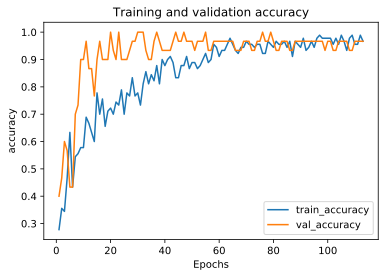

In [20]:
%matplotlib inline
plot_metric(history, 'accuracy')

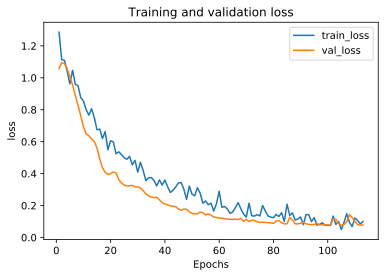

In [21]:
%matplotlib inline
plot_metric(history, 'loss')

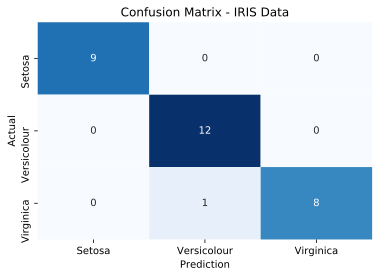

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
y_pred_predictions = np.argmax(model.predict(X_test), axis=1)
y_test_predictions = np.argmax(y_test, axis=1)
test_matrix = confusion_matrix(y_pred_predictions, y_test_predictions)
ax = sns.heatmap(test_matrix, annot = True, xticklabels = ["Setosa", "Versicolour", "Virginica"], yticklabels = ["Setosa", "Versicolour", "Virginica"], cbar = False, cmap = 'Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix - IRIS Data")
plt.show()

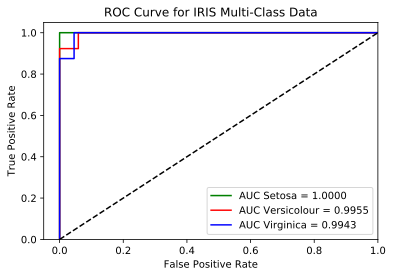

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
%matplotlib inline

y_score = model.predict(X_test)
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['green', 'red', 'blue'])
class_labels = ["Setosa", "Versicolour", "Virginica"]
for i, color, lbl in zip(range(n_classes), colors, class_labels):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'AUC {0} = {1:0.4f}'.format(lbl, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for IRIS Multi-Class Data')
plt.legend(loc = 'lower right', prop = {'size': 10})
plt.show()